In [25]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import matplotlib.pyplot as plt
from pprint import pp
import seaborn as sns

In [26]:
# Import and clean data
## NEWSPAPERS IDEOLOGY
newspaper_ideo_df = pd.read_csv("news_ideo_over_time.csv", keep_default_na=False)
#newspaper_ideo_df.rename({"published_date": "date"}, inplace=True, axis=1)
print(f'{newspaper_ideo_df["newspaper_ideo"].unique() = }')
print(newspaper_ideo_df.head())

## DEBATES
debates_df = pd.read_csv("speeches_per_date_party.csv", keep_default_na=False)
debates_df = debates_df.replace(    {"current_party": {
            "Centre": "Centre_parties"}})
print(debates_df.shape)
print(debates_df.head())
# check parties
print(f'{debates_df["current_party"].unique() = }')

newspaper_ideo_df["newspaper_ideo"].unique() = array(['Centre', 'Left-wing', 'Right-wing'], dtype=object)
         date newspaper_ideo  POSITIVE  NEGATIVE
0  2021-11-01         Centre         0         1
1  2021-11-01      Left-wing         0         1
2  2021-11-01     Right-wing         1         3
3  2021-11-02         Centre         0         1
4  2021-11-02      Left-wing         1         0
(1431, 4)
         date   current_party  POSITIVE  NEGATIVE
0  2021-11-01  Centre_parties         0         0
1  2021-11-01    Conservative         1         1
2  2021-11-01          Labour         0         0
3  2021-11-02  Centre_parties         0         0
4  2021-11-02    Conservative         1         0
debates_df["current_party"].unique() = array(['Centre_parties', 'Conservative', 'Labour'], dtype=object)


In [27]:
# reshape data to create a column per party/newspaper
## newspapers
newspaper_ideo_pivot = newspaper_ideo_df.pivot_table(
    values=("NEGATIVE", "POSITIVE"),
    index=["date"],
    columns=["newspaper_ideo"],
    aggfunc="sum",
)
# flatten
newspaper_ideo_pivot.columns = newspaper_ideo_pivot.columns.to_flat_index()
newspaper_ideo_pivot.reset_index(inplace=True)

print(newspaper_ideo_pivot.head(2))

## debates
debates_df_pivot = debates_df.pivot_table(
    values=("NEGATIVE", "POSITIVE"),
    index=["date"],
    columns=["current_party"],
    aggfunc="sum",
)
# flatten
debates_df_pivot.columns = debates_df_pivot.columns.to_flat_index()
newspaper_ideo_pivot.reset_index(inplace=True)

print(debates_df_pivot.head(2))


         date  (NEGATIVE, Centre)  (NEGATIVE, Left-wing)  \
0  2021-11-01                   1                      1   
1  2021-11-02                   1                      0   

   (NEGATIVE, Right-wing)  (POSITIVE, Centre)  (POSITIVE, Left-wing)  \
0                       3                   0                      0   
1                       4                   0                      1   

   (POSITIVE, Right-wing)  
0                       1  
1                       0  
            (NEGATIVE, Centre_parties)  (NEGATIVE, Conservative)  \
date                                                               
2021-11-01                           0                         1   
2021-11-02                           0                         0   

            (NEGATIVE, Labour)  (POSITIVE, Centre_parties)  \
date                                                         
2021-11-01                   0                           0   
2021-11-02                   0                           0 

In [28]:
## Joined on the newspaper dataset because lower max date
merged_df = newspaper_ideo_pivot.merge(
    debates_df_pivot, on="date", how="left", suffixes=("_newspapers", "_debates")
)
#fix date as index
merged_df.set_index("date", inplace=True)
merged_df = merged_df.drop('index', inplace=False, axis=1)

#fix colnames
merged_df.columns = [ "_".join(x) if type(x) == tuple else x for x in merged_df.columns]
print(merged_df.shape)
print(merged_df.head(2))

(477, 12)
            NEGATIVE_Centre  NEGATIVE_Left-wing  NEGATIVE_Right-wing  \
date                                                                   
2021-11-01                1                   1                    3   
2021-11-02                1                   0                    4   

            POSITIVE_Centre  POSITIVE_Left-wing  POSITIVE_Right-wing  \
date                                                                   
2021-11-01                0                   0                    1   
2021-11-02                0                   1                    0   

            NEGATIVE_Centre_parties  NEGATIVE_Conservative  NEGATIVE_Labour  \
date                                                                          
2021-11-01                        0                      1                0   
2021-11-02                        0                      0                0   

            POSITIVE_Centre_parties  POSITIVE_Conservative  POSITIVE_Labour  
date             

In [29]:
# Stationarity function
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [30]:
# Differencing
adf_test(merged_df["NEGATIVE_Centre"])

merged_df_diff = merged_df.diff()
merged_df_diff = merged_df_diff.iloc[1:]
adf_test(merged_df_diff["NEGATIVE_Centre"])
print(merged_df_diff.head(2))

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.288
p-value                  0.176
# lags used             13.000
# observations         463.000
critical value (1%)     -3.445
critical value (5%)     -2.868
critical value (10%)    -2.570
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: 
ADF test statistic      -9.537
p-value                  0.000
# lags used             12.000
# observations         463.000
critical value (1%)     -3.445
critical value (5%)     -2.868
critical value (10%)    -2.570
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
            NEGATIVE_Centre  NEGATIVE_Left-wing  NEGATIVE_Right-wing  \
date                                                                   
2021-11-02            0.000              -1.000                1.000   
2021-11-03            0.000               0.000          

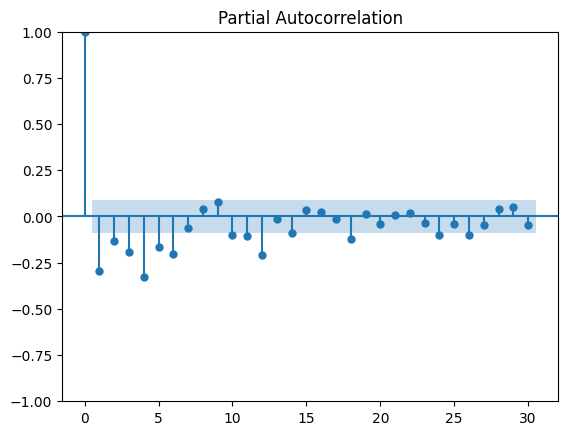

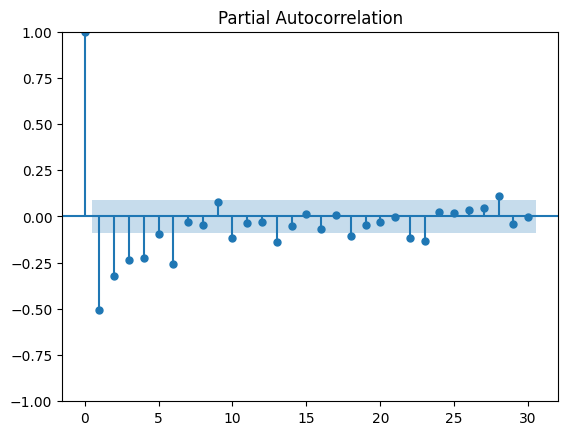

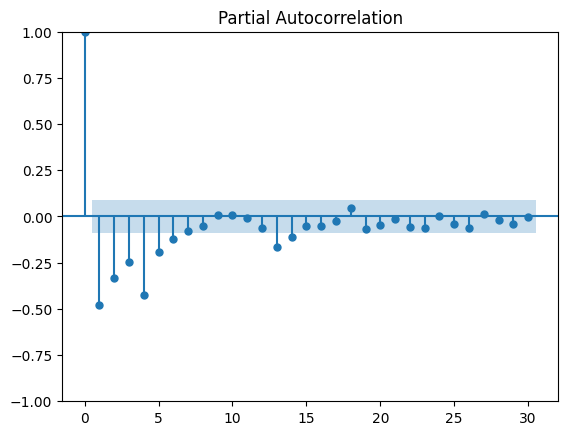

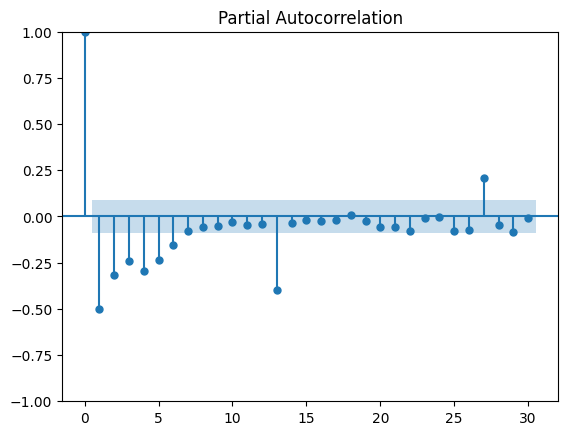

In [31]:
# Determine lags
plot_pacf(merged_df_diff["NEGATIVE_Left-wing"], method = "ols", lags = 30)
plt.show()
## lag 6 

plot_pacf(merged_df_diff["POSITIVE_Right-wing"], method = "ols", lags = 30)
plt.show()

plot_pacf(merged_df_diff["NEGATIVE_Conservative"], method = "ols", lags = 30)
plt.show()

plot_pacf(merged_df_diff["NEGATIVE_Labour"], method = "ols", lags = 30)
plt.show()
## lag 6 

                         NEGATIVE_Centre  NEGATIVE_Left-wing  \
NEGATIVE_Centre                    1.000               0.696   
NEGATIVE_Left-wing                 0.696               1.000   
NEGATIVE_Right-wing                0.735               0.684   
POSITIVE_Centre                    0.589               0.479   
POSITIVE_Left-wing                 0.443               0.402   
POSITIVE_Right-wing                0.474               0.435   
NEGATIVE_Centre_parties            0.203               0.187   
NEGATIVE_Conservative              0.230               0.244   
NEGATIVE_Labour                    0.233               0.225   
POSITIVE_Centre_parties            0.176               0.169   
POSITIVE_Conservative              0.260               0.261   
POSITIVE_Labour                    0.158               0.158   

                         NEGATIVE_Right-wing  POSITIVE_Centre  \
NEGATIVE_Centre                        0.735            0.589   
NEGATIVE_Left-wing                   

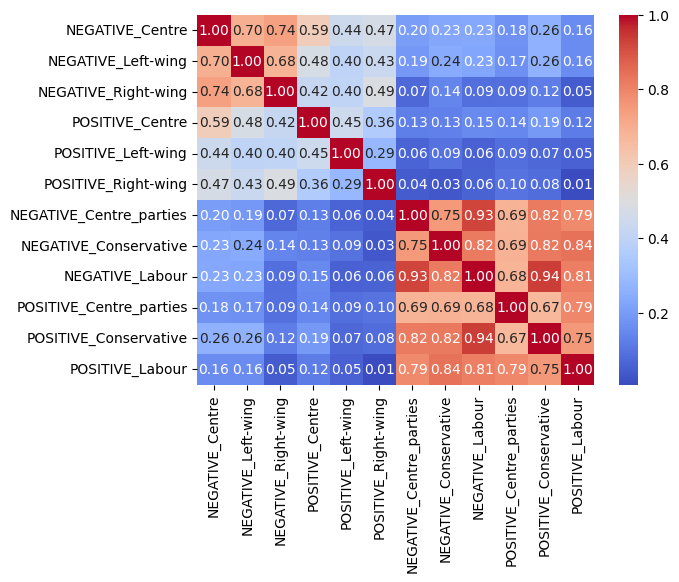

In [32]:
corr_matrix = merged_df.corr()

# Print the correlation matrix
pp(corr_matrix)

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

# Show the plot
plt.show()

In [33]:
model = VAR(merged_df_diff)
model_fit = model.fit(maxlags=7, ic="aic")
model_fit.summary()

/home/debian/miniconda3/envs/debates/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, May, 2023
Time:                     08:41:17
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    18.9781
Nobs:                     469.000    HQIC:                   13.5029
Log likelihood:          -9299.34    FPE:                    22021.7
AIC:                      9.95120    Det(Omega_mle):         2984.06
--------------------------------------------------------------------
Results for equation NEGATIVE_Centre
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              0.033837         0.123859            0.273           0.785
L1.NEGATIVE_Centre                -0.489526         0.058918           -8.309           0.00

In [34]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# get only significant p-values
model_pvalues = model_fit.pvalues

print(model_pvalues.columns)
print(model_pvalues.shape)

model_pvalues = model_pvalues.melt(value_vars=model_pvalues.columns, var_name = "y_variable", value_name = "pvalue", ignore_index=False)

print(model_pvalues.head())


model_pvalues = model_pvalues[model_pvalues["pvalue"] < 0.05]
model_pvalues.index.name = "x_variable" 

pp(model_pvalues)

model_pvalues.to_csv("varmodel_3_pvalues.csv", index=True)

Index(['NEGATIVE_Centre', 'NEGATIVE_Left-wing', 'NEGATIVE_Right-wing',
       'POSITIVE_Centre', 'POSITIVE_Left-wing', 'POSITIVE_Right-wing',
       'NEGATIVE_Centre_parties', 'NEGATIVE_Conservative', 'NEGATIVE_Labour',
       'POSITIVE_Centre_parties', 'POSITIVE_Conservative', 'POSITIVE_Labour'],
      dtype='object')
(85, 12)
                             y_variable  pvalue
const                   NEGATIVE_Centre   0.785
L1.NEGATIVE_Centre      NEGATIVE_Centre   0.000
L1.NEGATIVE_Left-wing   NEGATIVE_Centre   0.028
L1.NEGATIVE_Right-wing  NEGATIVE_Centre   0.877
L1.POSITIVE_Centre      NEGATIVE_Centre   0.984
                                 y_variable  pvalue
x_variable                                         
L1.NEGATIVE_Centre          NEGATIVE_Centre   0.000
L1.NEGATIVE_Left-wing       NEGATIVE_Centre   0.028
L1.NEGATIVE_Centre_parties  NEGATIVE_Centre   0.026
L1.POSITIVE_Centre_parties  NEGATIVE_Centre   0.000
L1.POSITIVE_Labour          NEGATIVE_Centre   0.000
...               

In [35]:
sorted_order=model.select_order(maxlags=7)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       17.68       17.79   4.781e+07       17.72
1       14.56       15.94   2.099e+06       15.10
2       13.05      15.71*   4.679e+05       14.10
3       12.44       16.37   2.536e+05       13.99
4       11.36       16.57   8.701e+04       13.41
5       10.89       17.37   5.446e+04       13.44
6       10.27       18.02   2.978e+04      13.32*
7      9.951*       18.98  2.202e+04*       13.50
-------------------------------------------------


In [36]:
model_fit.test_normality()
print(str(model_fit.test_normality()))

print(str(model_fit.test_whiteness(nlags=8)))

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 421095.920, critical value: 36.415>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 8 is zero: reject at 5% significance level. Test statistic: 689.155, critical value: 173.004>, p-value: 0.000>


FEVD for NEGATIVE_Centre
     NEGATIVE_Centre  NEGATIVE_Left-wing  NEGATIVE_Right-wing  POSITIVE_Centre  POSITIVE_Left-wing  POSITIVE_Right-wing  NEGATIVE_Centre_parties  NEGATIVE_Conservative  NEGATIVE_Labour  POSITIVE_Centre_parties  POSITIVE_Conservative  POSITIVE_Labour
0           1.000000            0.000000             0.000000         0.000000            0.000000             0.000000                 0.000000               0.000000         0.000000                 0.000000               0.000000         0.000000
1           0.907337            0.012198             0.000515         0.000967            0.001699             0.000001                 0.028005               0.000041         0.006893                 0.015575               0.000372         0.026397
2           0.841254            0.014997             0.003898         0.001697            0.002307             0.000729                 0.035026               0.013946         0.006274                 0.016273               0

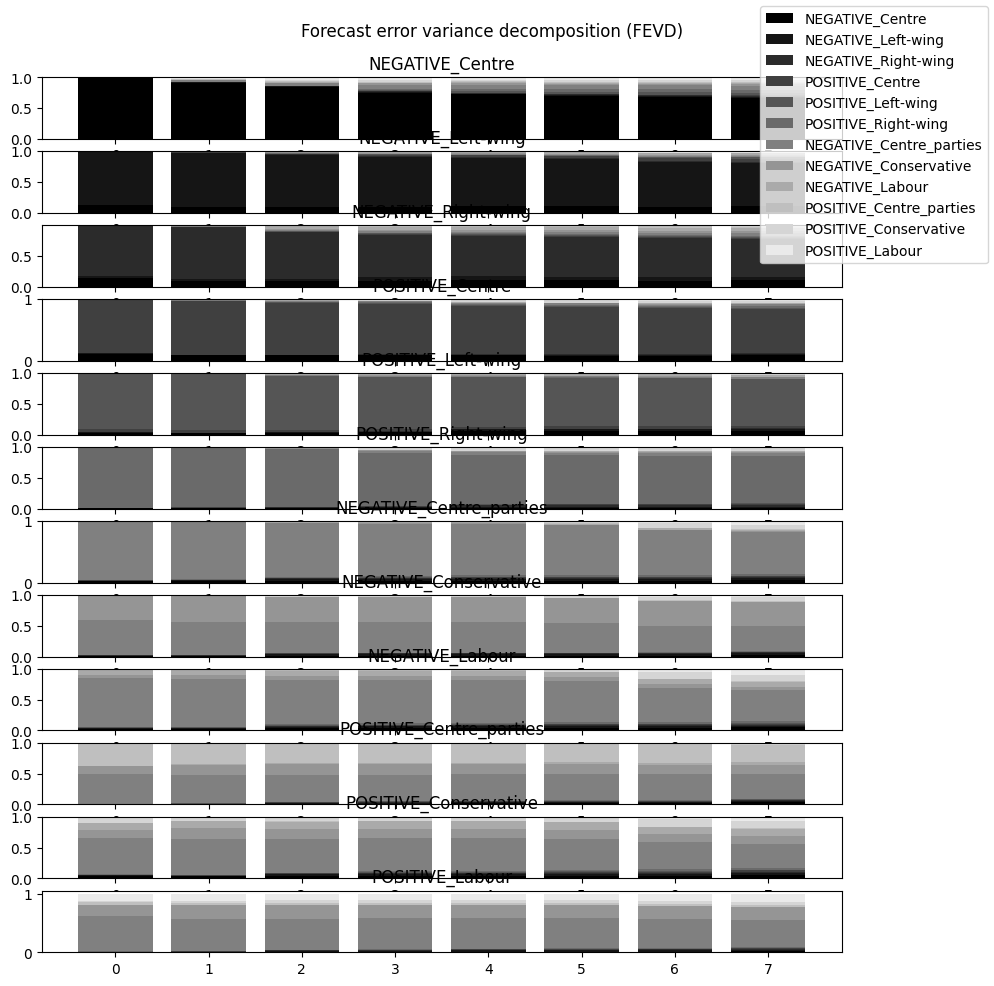

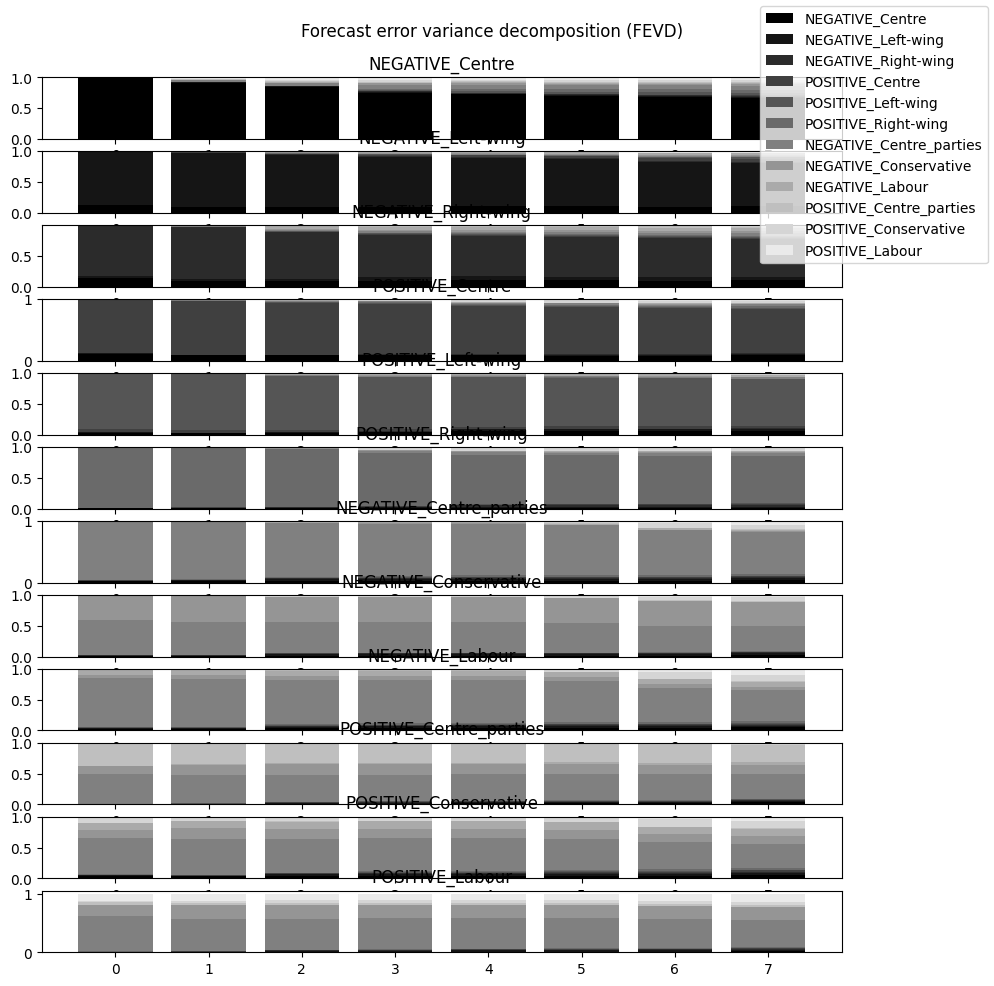

In [37]:
fevd = model_fit.fevd(8)
model_fevd = pd.DataFrame(fevd.summary())

model_fit.fevd(8).plot()

In [38]:
def granger_causality(data, maxlag):
    """
    Performs Granger causality tests for each variable in a dataset using a specified number of lags.

    Args:
    - data: A pandas DataFrame containing the time series data.
    - maxlag: An integer specifying the maximum number of lags to consider in the Granger causality tests.

    Returns:
    - A pandas DataFrame containing the p-values for each pairwise Granger causality test.
    """

    # Initialize an empty DataFrame to store the p-values
    #p_values = pd.DataFrame(columns=data.columns, index=data.columns)
    results: list[dict] = []
    # Loop through each pair of variables and perform a Granger causality test
    for i in range(len(data.columns)):
        for j in range(len(data.columns)):
            if i != j:
                # Select the two variables to test
                x = data.iloc[:, i]
                y = data.iloc[:, j]

                x_name = data.columns[i]
                y_name = data.columns[j]


                # Run the Granger causality test
                gc_result = grangercausalitytests(np.column_stack((x, y)), maxlag=maxlag, verbose=False)

                # Extract the p-value from the test results for each lag
                #p_values_list = []
                for lag in range(1, maxlag + 1):
                    p_value = gc_result[lag][0]['lrtest'][1]
                    #p_values_list.append(p_value)
                
                # Store the p-values in the DataFrame
                #p_values.iloc[i, j] = str(p_values_list)
                    result = {"x_name":x_name, "y_name":y_name, "lag":lag, "p-value":p_value}

                    results.append(result)

    return pd.DataFrame(results)               


In [39]:
results = granger_causality(merged_df_diff, 7)

print(results)

              x_name                 y_name  lag  p-value
0    NEGATIVE_Centre     NEGATIVE_Left-wing    1    0.007
1    NEGATIVE_Centre     NEGATIVE_Left-wing    2    0.001
2    NEGATIVE_Centre     NEGATIVE_Left-wing    3    0.000
3    NEGATIVE_Centre     NEGATIVE_Left-wing    4    0.000
4    NEGATIVE_Centre     NEGATIVE_Left-wing    5    0.001
..               ...                    ...  ...      ...
919  POSITIVE_Labour  POSITIVE_Conservative    3    0.756
920  POSITIVE_Labour  POSITIVE_Conservative    4    0.744
921  POSITIVE_Labour  POSITIVE_Conservative    5    0.263
922  POSITIVE_Labour  POSITIVE_Conservative    6    0.234
923  POSITIVE_Labour  POSITIVE_Conservative    7    0.289

[924 rows x 4 columns]
